In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
class Discriminator(nn.Module):
    def __init__(self,in_features):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(in_features,128),
            nn.LeakyReLU(0.01),
            nn.Linear(128,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.layer(x)

class Generator(nn.Module):
    def __init__(self,z_dim,img_dim):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(in_features=z_dim,out_features=256),
            nn.LeakyReLU(0.01),
            nn.Linear(256,img_dim),
            nn.Tanh()
        )

    def forward(self,z):
        return self.layer(z)

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

disc=Discriminator(image_dim).to(device)
gen=Generator(z_dim,image_dim).to(device)

noise=torch.rand(size=(batch_size,z_dim)).to(device)


transforms_=torchvision.transforms.Compose(
   [ torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,),std=(0.5,))]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms_, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

disc_opt=optim.Adam(disc.parameters(),lr=lr)
gen_opt=optim.Adam(params=gen.parameters(),lr=lr)

criterion=nn.BCELoss()

for epoch in range(num_epochs):
    for batch,(x,y) in enumerate(data_loader):
        x=x.view(-1,784).to(device)
        batch_size=x.shape[0]

        ###Training the discriminator
        noise=torch.randn(size=(batch_size,z_dim)).to(device)
        fake=gen(noise)
        disc_real=disc(x) # D(x)
        lossD_real=criterion(disc_real,torch.ones_like(disc_real)) # log(D(x))
        disc_fake=disc(fake) #D(G(x))
        lossD_fake=criterion(disc_fake,torch.zeros_like(disc_fake)) # log(1-D(G(x)))
        lossD=(lossD_real + lossD_fake) / 2

        disc.zero_grad()
        lossD.backward(retain_graph=True) #llows the generator’s computation graph to be reused after the discriminator’s backward pass
        disc_opt.step()


        ## Train the generator min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        gen_opt.step()
        if batch == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch}/{len(data_loader)} \
                        Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Epoch [0/50] Batch 0/1875                         Loss D: 0.7011, loss G: 0.6961
Epoch [1/50] Batch 0/1875                         Loss D: 0.3853, loss G: 1.3299
Epoch [2/50] Batch 0/1875                         Loss D: 0.4635, loss G: 1.2151
Epoch [3/50] Batch 0/1875                         Loss D: 0.4966, loss G: 1.3047
Epoch [4/50] Batch 0/1875                         Loss D: 0.5348, loss G: 1.0329
Epoch [5/50] Batch 0/1875                         Loss D: 0.8313, loss G: 0.6798
Epoch [6/50] Batch 0/1875                         Loss D: 0.4822, loss G: 1.1556
Epoch [7/50] Batch 0/1875                         Loss D: 0.7982, loss G: 0.8491
Epoch [8/50] Batch 0/1875                         Loss D: 0.5948, loss G: 1.1800
Epoch [9/50] Batch 0/1875                         Loss D: 0.4638, loss G: 1.3574
Epoch [10/50] Batch 0/1875                         Loss D: 0.3500, loss G: 2.0126
Epoch [11/50] Batch 0/1875     

Why `retain_graph=True` :  
The fake data here is generated by the generator. If we don’t retain the graph, PyTorch will delete it after calculating the gradients for the discriminator. But we still need that graph later when we train the generator.

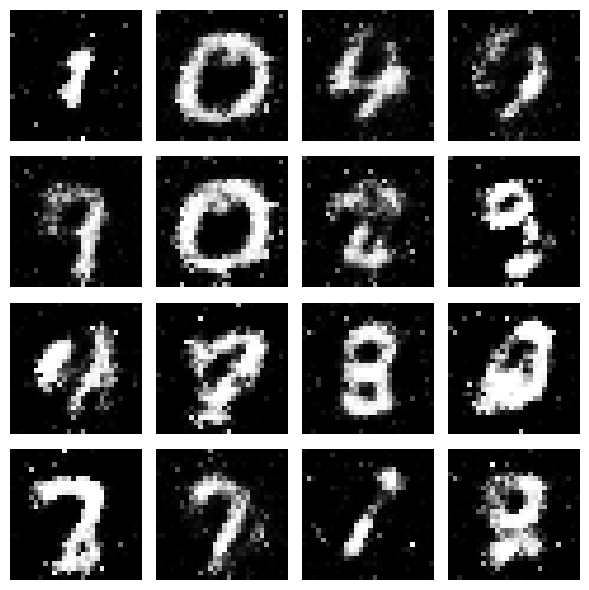

In [4]:
import matplotlib.pyplot as plt

noise = torch.randn(size=(16, z_dim)).to(device)

gen.eval()
with torch.no_grad():
    fake_images = gen(noise).reshape(-1, 1, 28, 28).cpu()
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()